In [1]:
# increase cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import gc
import os
import time

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils import class_weight

In [5]:
import tensorflow as tf
from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense, Activation, Dropout
from tensorflow.python.keras import metrics

from tensorflow.python.keras.layers import Conv1D
from tensorflow.python.keras.layers import MaxPooling1D
from tensorflow.python.keras.layers import GlobalAveragePooling1D
from tensorflow.python.keras.layers import GlobalMaxPooling1D

In [6]:
final_df = pd.read_csv('./consolidated_4_10pct_sample_ext.csv')
final_df.shape

(1244493, 164)

In [7]:
def split_train_test(data, features):
    indexer = data[['s2_cell_id','measure_date']].copy()
    train = data[data.measure_date < '2018-01-01'].copy()
    test = data[data.measure_date >= '2018-01-01'].copy()
    
    y_train = train.wf_wildfire.copy().values
    y_test = test.wf_wildfire.copy().values    
    
    y_train_ext = train.wf_wildfire_ext.copy().values
    y_test_ext = test.wf_wildfire_ext.copy().values    

    train = train[features]
    test = test[features]    
    
    test_ids = data[data.measure_date >= '2018-01-01'][['s2_cell_id', 'measure_date']]
    
    return train, test, y_train, y_test, y_train_ext, y_test_ext, test_ids

In [8]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    Source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

    Prints and plots the confusion matrix.

    Args:
        y_true: list of true target labels
        y_pred: list of predicted target labels
        classes: tuple of class labels in 0, 1 order

    Kwargs:
        normalize: bool, normalize confusion matrix or not
        cmap: color map
    """

    if normalize:
        title = 'Normalized confusion matrix'
    else:
        title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print('Confusion matrix, without normalization')
    print(cm)

    print(classification_report(y_true, y_pred, target_names=classes))

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes,
           yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(),
             rotation=45,
             ha="right",
             rotation_mode="anchor")

    # loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()
    return ax

In [9]:
def bin_prob(probs, y_test):
    y_binned = np.digitize(probs, np.arange(0,1.1,0.1))
    bin_df = pd.DataFrame(list(zip(y_test, probs, y_binned)), columns =['Actual', 'Prob', 'Bin'])
    bin_df = bin_df.groupby('Bin').agg({'Actual': ['mean', 'sum', 'count'], 'Prob': 'mean'})
    return bin_df

In [10]:
class TimeHistory(tf.keras.callbacks.Callback):
    """
    https://stackoverflow.com/questions/43178668/
    record-the-computation-time-for-each-epoch-in-keras-during-model-fit
    """

    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [11]:
def mlp_model(layers, units, dropout_rate, input_shape, op_units, op_activation):
    """
    Creates an instance of a multi-layer perceptron model.

    Arguments
      layers: int, number of `Dense` layers in the model.
      units: int, output dimension of the layers.
      dropout_rate: float, percentage of input to drop at Dropout layers.
      input_shape: tuple, shape of input to the model.
      op_units: number of output units (1 for binary target)
      op_activation: activation function (sigmoid for binary target)

    Returns
      An MLP model instance.
    """

    model = models.Sequential()
    model.add(Dropout(rate=dropout_rate, input_shape=input_shape))

    for _ in range(layers - 1):
        model.add(Dense(units=units, activation='relu'))
        model.add(Dropout(rate=dropout_rate))

    model.add(Dense(units=op_units, activation=op_activation))

    return model

In [12]:
def train_model(data,
                model_type='cnn',
                learning_rate=1e-3,
                epochs=1000,
                batch_size=128,
                blocks=2,
                filters=64,
                layers=2,
                units=64,
                dropout_rate=0.2,
                kernel_size=3,
                pool_size=3,
                num_classes=2,
                class_weights={0:1.,1:1.}):
    """
    Trains sequence model on the given dataset.

    Args:
      data: tuples of vectorized training and test texts and labels.
      log_dir: directory to write logs to

    Kwargs:
      model_type: str, type of model to train
      word_index: word_index if applicable
      learning_rate: float, learning rate for training model.
      epochs: int, number of epochs.
      batch_size: int, number of samples per batch.
      blocks: int, number of pairs of sepCNN and pooling blocks in the model.
      filters: int, output dimension of sepCNN layers in the model.
      dropout_rate: float: percentage of input to drop at Dropout layers.
      embedding_dim: int, dimension of the embedding vectors.
      kernel_size: int, length of the convolution window.
      pool_size: int, factor by which to downscale input at MaxPooling layer.
      max_num_words: int, max number of features to use
      num_classes: int, number of classes in the target variable
      use_pretrained_embedding: bool, use pretrained embeddings or no
      is_embedding_trainable: bool, train embeddings or no
      use_word_embedding: bool, False if sentence encodding is used
      glove_dir: directory with glove embeddings if applicable
    """

    # Get the data.
    x_train, train_labels, x_val, val_labels = data

    if num_classes == 2:
        op_units, op_activation = 1, 'sigmoid'
    else:
        op_units, op_activation = num_classes, 'softmax'

    # Create model instance.
    if model_type == 'cnn':
        model = cnn_model(filters=filters,
                          kernel_size=kernel_size,
                          layers=layers,
                          dropout_rate=dropout_rate,
                          pool_size=pool_size,
                          input_shape=x_train.shape[1:],
                          op_units=op_units,
                          op_activation=op_activation)
    elif model_type == 'mlp':
        model = mlp_model(layers=layers,
                          units=units,
                          dropout_rate=dropout_rate,
                          input_shape=x_train.shape[1:],
                          op_units=op_units,
                          op_activation=op_activation)

    # Compile model with learning parameters.
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
#     optimizer = tf.keras.optimizers.RMSprop(lr=learning_rate) - didn't work (too many false negatives)
#     optimizer = tf.keras.optimizers.SGD(lr=learning_rate) - similar performance to Adam
#     optimizer = tf.keras.optimizers.Adagrad(lr=learning_rate) - didn't work (too many false positives)
    model.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=[metrics.Recall()])

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in two consecutive tries, stop training.
    callbacks = [
#           tf.keras.callbacks.EarlyStopping(monitor='val_loss',
#                                            patience=2),
          TimeHistory()]

    # Train and validate model.
    history = model.fit(
      x_train,
      train_labels,
      epochs=epochs,
      callbacks=callbacks,
      validation_data=(x_val, val_labels),
      verbose=2,  # Logs once per epoch.
      batch_size=batch_size,
      class_weight=class_weights)

    train_pred_probs = model.predict(x_train)
    val_pred_probs = model.predict(x_val)

    return history.history, model, train_pred_probs, val_pred_probs

In [13]:
scaler = MinMaxScaler()

## Optimizer: Adam; Features: - precipitation

In [14]:
tl_features = [
    'tl_object_id',
    'tl_kv_sort_sum'
]

wf_features = [
    'wf_count_1yr_ago',
    'wf_count_2yr_ago',
    'wf_count_3yr_ago',
    'wf_count_4yr_ago',
    'wf_count_5yr_ago'
]

sat_features = [
 'sat_faparval_min',
 'sat_faparval_max',
 'sat_faparval_mean',
#  'sat_faparval_median',
 'sat_faparval_std',
 'sat_faparval_size',
 'sat_faparval_count',
 'sat_faparval',
 'sat_faparmask_min',
 'sat_faparmask_max',
 'sat_faparmask_mean',
#  'sat_faparmask_median',
 'sat_faparmask_std',
 'sat_faparmask_size'
]

wea_features = [
 'wea_air_temp_max',
 'wea_air_temp_mean',
#  'wea_precip_accum_max',
 'relative_humidity_max',
 'relative_humidity_min',
 'relative_humidity_mean',
 'wea_wind_speed_max',
 'wea_wind_speed_min',
 'wea_wind_speed_mean',
 'wind_gust_max',
 'wea_air_temp_mean_ma7',
#  'wea_precip_accum_max_ma7',
 'relative_humidity_mean_ma7',
 'wea_air_temp_mean_l1',
#  'wea_precip_accum_max_l1',
 'relative_humidity_mean_l1'
]

new_features = [
 'fuel_percent_ma7',
 'fuel_percent_ma30',
 'fuel_percent_l1',
 'wea_air_temp_mean_ma30',
#  'wea_precip_accum_max_ma30',
 'relative_humidity_mean_ma30'
]

In [15]:
gc.collect()
feature_cols = wea_features + tl_features + sat_features + ['fuel_percent'] + new_features
train, test, y_train, y_test, y_train_ext, y_test_ext, test_ids = split_train_test(final_df, feature_cols)

In [16]:
train.shape, test.shape

((825403, 33), (419090, 33))

In [17]:
train_sc = scaler.fit_transform(train)
test_sc = scaler.transform(test)

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [18]:
cw = class_weight.compute_class_weight('balanced', np.unique(y_train_ext), y_train_ext)
cw

array([0.53436386, 7.77508478])

In [19]:
model_params = {
    'model_type': 'mlp',
    'learning_rate': 1e-3,
    'epochs': 20,
    'batch_size': 128,
    'layers': 2,
    'units': 64,
    'dropout_rate': 0.2,
    'class_weights': {0: cw[0], 1: cw[1]}
}

In [20]:
gc.collect()
history, model_mlp, train_pred_probs, test_pred_probs = train_model((train_sc, y_train_ext, test_sc, y_test_ext), **model_params)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Colocations handled automatically by placer.
Train on 825403 samples, validate on 419090 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
 - 10s - loss: 0.5746 - recall: 0.7459 - val_loss: 0.8415 - val_recall: 0.9362
Epoch 2/20
 - 10s - loss: 0.5387 - recall: 0.7959 - val_loss: 0.7808 - val_recall: 0.9299
Epoch 3/20
 - 10s - loss: 0.5270 - recall: 0.8041 - val_loss: 0.7684 - val_recall: 0.9102
Epoch 4/20
 - 10s - loss: 0.5228 - recall: 0.8081 - val_loss: 0.6887 - val_recall: 0.8958
Epoch 5/20
 - 9s - loss: 0.5185 - recall: 0.8111 - val_loss: 0.7532 - val_recall: 0.9167
Epoch 6/20
 - 10s - loss: 0.5159 - recall: 0.8118 - val_loss: 0.6970 - val_recall: 0.8970
Epoch 7/20
 - 10s - loss: 0.5144 - recall: 0.8142 - val_loss: 0.7006 - val_recall: 0.8938
Epoch 8/20
 - 10s - loss: 0.5127 - recall: 0.8128 - val_loss: 0.6602 - val_recall: 0

In [21]:
model_mlp.save('./Models/mlp_adam_noprecip_cwEQ_ext.h5')

In [22]:
bin_prob(test_pred_probs[:,0], y_test)

Actual                    Prob
         mean    sum  count      mean
Bin                                  
1    0.000215    5.0  23303  0.050705
2    0.000818   20.0  24456  0.151107
3    0.001800   56.0  31114  0.253315
4    0.001859   92.0  49478  0.353650
5    0.002919  215.0  73660  0.452401
6    0.003532  297.0  84093  0.550290
7    0.004403  338.0  76773  0.648132
8    0.003795  186.0  49018  0.741991
9    0.004638   33.0   7115  0.822594
10   0.000000    0.0     50  0.946869
11   0.000000    0.0     30  1.000000

In [23]:
test_preds = test_pred_probs[:,0]>0.5
test_preds.sum()

217079

Confusion matrix, without normalization
[[201623 216225]
 [   388    854]]
              precision    recall  f1-score   support

         nwf       1.00      0.48      0.65    417848
          wf       0.00      0.69      0.01      1242

   micro avg       0.48      0.48      0.48    419090
   macro avg       0.50      0.59      0.33    419090
weighted avg       1.00      0.48      0.65    419090



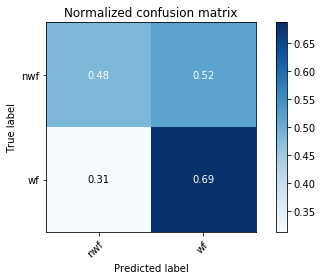

In [24]:
plot_confusion_matrix(y_test, test_preds, ['nwf', 'wf'], normalize=True)

## Optimizer: Adam; Features: + precipitation

In [25]:
tl_features = [
    'tl_object_id',
    'tl_kv_sort_sum'
]

wf_features = [
    'wf_count_1yr_ago',
    'wf_count_2yr_ago',
    'wf_count_3yr_ago',
    'wf_count_4yr_ago',
    'wf_count_5yr_ago'
]

sat_features = [
 'sat_faparval_min',
 'sat_faparval_max',
 'sat_faparval_mean',
#  'sat_faparval_median',
 'sat_faparval_std',
 'sat_faparval_size',
 'sat_faparval_count',
 'sat_faparval',
 'sat_faparmask_min',
 'sat_faparmask_max',
 'sat_faparmask_mean',
#  'sat_faparmask_median',
 'sat_faparmask_std',
 'sat_faparmask_size'
]

wea_features = [
 'wea_air_temp_max',
 'wea_air_temp_mean',
 'wea_precip_accum_max',
 'relative_humidity_max',
 'relative_humidity_min',
 'relative_humidity_mean',
 'wea_wind_speed_max',
 'wea_wind_speed_min',
 'wea_wind_speed_mean',
 'wind_gust_max',
 'wea_air_temp_mean_ma7',
 'wea_precip_accum_max_ma7',
 'relative_humidity_mean_ma7',
 'wea_air_temp_mean_l1',
 'wea_precip_accum_max_l1',
 'relative_humidity_mean_l1'
]

new_features = [
 'fuel_percent_ma7',
 'fuel_percent_ma30',
 'fuel_percent_l1',
 'wea_air_temp_mean_ma30',
 'wea_precip_accum_max_ma30',
 'relative_humidity_mean_ma30'
]

In [26]:
gc.collect()
feature_cols = wea_features + tl_features + sat_features + ['fuel_percent'] + new_features
train, test, y_train, y_test, y_train_ext, y_test_ext, test_ids = split_train_test(final_df, feature_cols)

train_sc = scaler.fit_transform(train)
test_sc = scaler.transform(test)

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [27]:
model_params = {
    'model_type': 'mlp',
    'learning_rate': 0.001,
    'epochs': 20,
    'batch_size': 128,
    'layers': 2,
    'units': 64,
    'dropout_rate': 0.2,
    'class_weights': {0: cw[0], 1: cw[1]}
}

In [28]:
gc.collect()
history, model_mlp, train_pred_probs, test_pred_probs = train_model((train_sc, y_train_ext, test_sc, y_test_ext), **model_params)

Train on 825403 samples, validate on 419090 samples
Epoch 1/20
 - 10s - loss: 0.5623 - recall_1: 0.7524 - val_loss: 0.7551 - val_recall_1: 0.9056
Epoch 2/20
 - 10s - loss: 0.5092 - recall_1: 0.7984 - val_loss: 0.7254 - val_recall_1: 0.8727
Epoch 3/20
 - 10s - loss: 0.4952 - recall_1: 0.7984 - val_loss: 0.6642 - val_recall_1: 0.8286
Epoch 4/20
 - 10s - loss: 0.4883 - recall_1: 0.8021 - val_loss: 0.6874 - val_recall_1: 0.8491
Epoch 5/20
 - 10s - loss: 0.4848 - recall_1: 0.8053 - val_loss: 0.6843 - val_recall_1: 0.8073
Epoch 6/20
 - 10s - loss: 0.4815 - recall_1: 0.8064 - val_loss: 0.7052 - val_recall_1: 0.8091
Epoch 7/20
 - 10s - loss: 0.4786 - recall_1: 0.8072 - val_loss: 0.7043 - val_recall_1: 0.8192
Epoch 8/20
 - 10s - loss: 0.4763 - recall_1: 0.8094 - val_loss: 0.6349 - val_recall_1: 0.8205
Epoch 9/20
 - 10s - loss: 0.4746 - recall_1: 0.8127 - val_loss: 0.6366 - val_recall_1: 0.8126
Epoch 10/20
 - 10s - loss: 0.4741 - recall_1: 0.8118 - val_loss: 0.6539 - val_recall_1: 0.8109
Epoch 1

In [29]:
model_mlp.save('./Models/mlp_adam_precip_cwEQ_ext.h5')

In [30]:
bin_prob(test_pred_probs[:,0], y_test)

Actual                    Prob
         mean    sum  count      mean
Bin                                  
1    0.000430   13.0  30217  0.053640
2    0.000791   30.0  37950  0.152313
3    0.001419   71.0  50039  0.251968
4    0.002112  122.0  57772  0.350540
5    0.004016  262.0  65235  0.450915
6    0.004729  299.0  63222  0.548956
7    0.004775  262.0  54864  0.646747
8    0.003553  127.0  35748  0.748075
9    0.002377   51.0  21457  0.840028
10   0.001952    5.0   2561  0.923023
11   0.000000    0.0     25  1.000000

In [31]:
test_preds = test_pred_probs[:,0]>0.5
test_preds.sum()

177877

Confusion matrix, without normalization
[[240715 177133]
 [   498    744]]
              precision    recall  f1-score   support

         nwf       1.00      0.58      0.73    417848
          wf       0.00      0.60      0.01      1242

   micro avg       0.58      0.58      0.58    419090
   macro avg       0.50      0.59      0.37    419090
weighted avg       0.99      0.58      0.73    419090



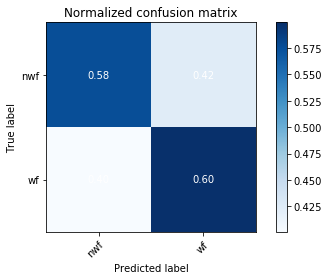

In [32]:
plot_confusion_matrix(y_test, test_preds, ['nwf', 'wf'], normalize=True)

In [33]:
gc.collect()

200